In [9]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk

import pickle
import shutil
import os
import glob

In [10]:
class RealTimeShelve:
    def __init__(self, savedir='./shelf/'):
        """
        ファイルを毎回外部に保存/外部から読み取ることで、
        subprocess等を使わずにプロセス間で値を共有する
        """
        self.savedir = savedir
        os.makedirs(self.savedir, exist_ok=True)
    
    def path(self, key):
        return f"{self.savedir}{key}.pkl"
    
    def path2key(self, path):
        return '.'.join(path.split('\\')[-1].split('.')[:-1])
    
    def __setitem__(self, key, value):
        with open(self.path(key), 'wb') as f:
            pickle.dump(value, f)

    def __getitem__(self, key):
        if os.path.exists(self.path(key)):
            with open(self.path(key), 'rb') as f:
                return pickle.load(f)
        else:
            raise KeyError(key)
    
    def _get_dict(self):
        d = {}
        for path in glob.glob(f"{self.savedir}*"):
            with open(path, 'rb') as f:
                d[self.path2key(path)] = pickle.load(f)
        return d
    
    def items(self):
        return self._get_dict().items()
    
    def keys(self):
        return self._get_dict().keys()
    
    def values(self):
        return self._get_dict().values()
    
    def __iter__(self):
        yield from self.keys()

In [11]:
class TkParams:
    def __init__(self, savedir='./tk_params/', reset=False):
        self.savedir = savedir
        if reset:
            shutil.rmtree(savedir)
            os.makedirs(savedir)
            os.makedirs(f"{savedir}widgets/")
        
        self.widgets = {
            "slider": RealTimeShelve(f"{savedir}widgets/slider/"),
        }
        
        self.sliders = RealTimeShelve(f"{savedir}slider/")
        
    
    def __del__(self):
        self.sliders.close()
        
    def get_float(self, key, from_=0, to=1, resolution=None, default=None):
        if key in self.sliders:
            # GUIにすでにウィジェットがあったら
            return float(self.sliders[key])
        else:
            # GUIにまだウィジェットがなかったら
            # ウィジェットを追加するよう伝えつつ、今回はデフォルト値を返す
            self.widgets["slider"][key] = {
                'name': key,
                'from_': from_,
                'to': to,
                'resolution': resolution,
                'default': default,
            }
            return from_ if default is None else default

In [12]:
class Application(tk.Tk):
    def __init__(self, title='GUI App', dt=100):
        super().__init__()
        self.title(title)
        
        # 画面をグラフを配置する場所とボタン等を配置する場所に分ける
        self.canvas_frame = tk.Frame(self)
        self.canvas_frame.pack(side=tk.LEFT)
        self.control_frame = tk.Frame(self)
        self.control_frame.pack(side=tk.RIGHT)
        
        #self.figures = {}
        self.sliders = {}
        
        self.tkparams = TkParams(reset=True)
        
        self.dt = dt
        self.update_widget()

    def add_figure(self, name, init_anim, update_anim):
        #self.figures[name] = Figure(self, name, init_anim, update_anim)
        self.figure = Figure(self, name, init_anim, update_anim)
        
    def add_slider(self, name, from_=0, to=1, resolution=None, default=None):
        self.sliders[name] = Slider(self, name, from_, to, resolution, default)
    
    def update_widget(self):
        slider_params = self.tkparams.widgets["slider"]
        for name in (set(slider_params) - set(self.sliders)): # まだ追加していないスライダーについてループ
            self.add_slider(**slider_params[name])
            
        # dt[ms]後にこの関数自身を呼び出す
        self.after(self.dt, self.update_widget)

class Figure:
    def __init__(self, app, name, init_anim, update_anim):
        self.app = app
        self.name = name
        
        self.fig = plt.figure(figsize=(5, 5))
        self.ax = self.fig.add_subplot(111)
        self.canvas = FigureCanvasTkAgg(self.fig, self.app.canvas_frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        self.init_anim = lambda : init_anim(self.ax)
        self.update_anim = update_anim
        
        self.ani = None
        self.draw_plot()
        
    def draw_plot(self, event=None):
           # すでにアニメーションが実行されている場合はevent_source.stopで停止
        if self.ani is not None:
            self.ani.event_source.stop()
            self.ax.clear()

        self.ani = FuncAnimation(
              self.fig,  # Figureオブジェクト
              self.update_anim,  # グラフ更新関数
              init_func=self.init_anim,  # 初期化関数
              interval = self.app.dt,  # 更新間隔(ms)
              blit = True,
        )
        self.canvas.draw()
        
class Slider:
    def __init__(self, app, name, from_=0, to=1, resolution=None, default=None):
        self.app = app
        self.name = name
        self.app.tkparams.sliders[self.name] = from_ if default is None else default
        
        self.control_label = tk.Label(app.control_frame, text=self.name)
        self.control_label.pack(anchor=tk.NW)
        self.var = tk.DoubleVar()
        self.x_scale = tk.Scale(
            self.app.control_frame,
            variable=self.var,
            from_=from_,
            to=to,
            resolution=(to - from_) * 0.01 if resolution is None else resolution,
            orient=tk.HORIZONTAL,
            command=self.on_change,
        )
        self.x_scale.pack(anchor=tk.NW)
        
    def on_change(self, event=None):
        self.app.tkparams.sliders[self.name] = self.var.get()
        self.app.figure.draw_plot()

In [13]:
class Furiko:
    def __init__(self):
        self.tkparams = TkParams()
        self.reset()
        
    def reset(self):
        bpm = max(30, self.tkparams.get_float('bpm', 30, 200))
        self.g = 9.8   # 重力加速度
        self.T = round(1 / (bpm / 60), 2) # BPを取得し、周期の計算
        self.l = (self.T ** 2) * self.g / (4 * np.pi ** 2)  # 振り子の長さを計算
        self.theta_0 = np.pi / 4               # 初期の角度
        self.omega = np.sqrt(self.g / self.l)  # 角速度
        
    def init_anim(self, ax):
        '''アニメーション初期化用の関数'''
        ax.set_xlim(-1.2,1.2)
        ax.set_ylim(-1.2,1.2)
        self.im, = ax.plot([], [], color='k', marker='o', \
                                    markersize=12, linestyle='None')
        self.line, = ax.plot([], [], color='k')
        
        return self.im, self.line

    def update_anim(self, dt):
        '''グラフ更新関数'''
        self.reset()
        
        self.theta = self.theta_0 * np.cos(self.omega * dt / 20)
        x = self.l * np.sin(self.theta)
        y = - self.l * np.cos(self.theta)
        self.im.set_data(x, y)
        self.line.set_data([0, np.sin(self.theta)], [0, -np.cos(self.theta)])
        return self.im, self.line

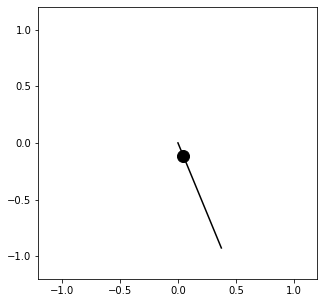

In [14]:
app = Application(dt=50)
furiko = Furiko()
app.add_figure('furiko', furiko.init_anim, furiko.update_anim)
app.mainloop()